# Part 1: Data Analysis
## Chapter 2: Financial Data Structure

In [1]:
import gc
import os
import jesse.helpers as jh

if not jh.is_jesse_project():
    os.chdir("..")

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import statsmodels.api as sm

def plot_autocorr(title: str, bar_return: np.ndarray, ax):
    sm.graphics.tsa.plot_acf(bar_return, lags=120, ax=ax,
                             alpha=0.05, unbiased=True, fft=True,
                             zero=False, auto_ylims=True,
                             title=title)
    
    plt.tight_layout()  


def plot_candles_sticks(df: pd.DataFrame, title: str | None):
        
    fig = go.Figure(data=[go.Candlestick(x=pd.to_datetime(df['time'], unit='ms'),
                                         open=df['open'],
                                         high=df['high'],
                                         low=df['low'],
                                         close=df['close'])])
    if title:
        fig.update_layout(
            title=title,
        )
        
    return fig

def plot_prices(df: pd.DataFrame, title: str | None = None):
    
    plt.plot(pd.to_datetime(df['time'], unit='ms'), df['close'])
    if title:
        plt.title(title)

In [3]:

def reduce_memory_usage(df: pd.DataFrame) -> pd.DataFrame:
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()

            if pd.api.types.is_float_dtype(col_type):
                df[col] = pd.to_numeric(df[col], downcast='float')
            elif pd.api.types.is_integer_dtype(col_type):
                if c_min >= 0:
                    if c_max < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif c_max < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif c_max < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    else:
                        df[col] = df[col].astype(np.int64)
        else:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    print(f'Decreased by {(start_mem - end_mem) / start_mem * 100:.1f}%')

    return df

# the data is downloaded im using is crypto ticker data from
# https://www.binance.com/en/landing/data
# using BTC for this exercise download data of 5 months
def load_df(file: str) -> pd.DataFrame:
    df = pd.read_csv(file)
    del df['id']
    del df['quote_qty']
    del df['is_buyer_maker']
    gc.collect()
    return reduce_memory_usage(df)

In [4]:
dates = ['2024-03', '2024-04', '2024-05']
btc_transactions = reduce_memory_usage(
    pd.concat([
        load_df(f"Advances-In-Financial-Machine-Learning\data\BTCUSDT-trades-{date}.csv")
        for date in dates
    ])
)

Memory usage of dataframe is 3671.92 MB
Memory usage after optimization is: 2447.95 MB
Decreased by 33.3%
Memory usage of dataframe is 3093.14 MB
Memory usage after optimization is: 2062.09 MB
Decreased by 33.3%
Memory usage of dataframe is 2326.83 MB
Memory usage after optimization is: 1551.22 MB
Decreased by 33.3%
Memory usage of dataframe is 9091.89 MB
Memory usage after optimization is: 9091.89 MB
Decreased by 0.0%


### 2.1 On a series of E-mini S&P 500 futures tick data: (I'll use BTC)

#### (a) Form tick, volume, and dollar bars. Use the ETF trick to deal with the roll.


In [80]:
def create_time_bars(transaction_df, T):
    # Convert epoch timestamp to datetime
    transaction_df['dt_time'] = pd.to_datetime(transaction_df['time'], unit='ms')
    transaction_df.set_index('dt_time', inplace=True)
    
    # Resample the dataframe to create bars for every T minutes
    if T[-1] == 'm':
        T = T[:-1] + 'min'
    resampled_df = transaction_df.resample(T).agg({
        'price': ['first', 'max', 'min', 'last'],
        'qty': 'sum'
    })
    
    resampled_df.columns = ['open', 'high', 'low', 'close', 'volume']
    resampled_df.dropna(inplace=True)
    resampled_df.reset_index(inplace=True)
    resampled_df['time'] = resampled_df['dt_time']
    del resampled_df['dt_time']
    gc.collect()
    
    return resampled_df

def create_tick_bars(transaction_df, T):
    transaction_df = transaction_df.sort_values(by='time').reset_index(drop=True)
    n_bars = len(transaction_df) // T
    transactions = transaction_df.iloc[:n_bars * T]
    chunks = transactions.values.reshape(n_bars, T, -1)
    times = chunks[:, :, transaction_df.columns.get_loc('time')]
    prices = chunks[:, :, transaction_df.columns.get_loc('price')]
    qtys = chunks[:, :, transaction_df.columns.get_loc('qty')]
    
    times_end = times[:, -1]
    opens = prices[:, 0]
    highs = prices.max(axis=1)
    lows = prices.min(axis=1)
    closes = prices[:, -1]
    volumes = qtys.sum(axis=1)
    
    tick_bars_df = pd.DataFrame({
        'time': times_end,
        'open': opens,
        'high': highs,
        'low': lows,
        'close': closes,
        'volume': volumes
    })
    
    return reduce_memory_usage(tick_bars_df)



def create_volume_bars(transaction_df, T):
    transaction_df = transaction_df.sort_values(by='time').reset_index(drop=True)
    transaction_df['cumulative_volume'] = transaction_df['qty'].cumsum()
    # Identify the indices where the cumulative volume reaches the threshold T
    volume_thresholds = np.arange(T, transaction_df['cumulative_volume'].max(), T)
    volume_bar_indices = np.searchsorted(transaction_df['cumulative_volume'].values, volume_thresholds)
    
    times = []
    opens = []
    highs = []
    lows = []
    closes = []
    volumes = []
    previous_index = 0
    for index in volume_bar_indices:
        if previous_index != index:
            chunk = transaction_df.iloc[previous_index:index]
        times.append(chunk['time'].iloc[-1])
        opens.append(chunk['price'].iloc[0])
        highs.append(chunk['price'].max())
        lows.append(chunk['price'].min())
        closes.append(chunk['price'].iloc[-1])
        volumes.append(chunk['qty'].sum())
        previous_index = index
    
    volume_bars_df = pd.DataFrame({
        'time': times,
        'open': opens,
        'high': highs,
        'low': lows,
        'close': closes,
        'volume': volumes
    })
    
    return reduce_memory_usage(volume_bars_df)

def create_dollar_bars(transaction_df, T):
    transaction_df = transaction_df.sort_values(by='time').reset_index(drop=True)
    transaction_df['cumulative_dollar'] = (transaction_df['price']*transaction_df['qty']).cumsum()
    # Identify the indices where the cumulative volume reaches the threshold T
    volume_thresholds = np.arange(T, transaction_df['cumulative_dollar'].max(), T)
    volume_bar_indices = np.searchsorted(transaction_df['cumulative_dollar'].values, volume_thresholds)
    
    times = []
    opens = []
    highs = []
    lows = []
    closes = []
    volumes = []
    previous_index = 0
    for index in volume_bar_indices:
        if previous_index != index:
            chunk = transaction_df.iloc[previous_index:index]
        times.append(chunk['time'].iloc[-1])
        opens.append(chunk['price'].iloc[0])
        highs.append(chunk['price'].max())
        lows.append(chunk['price'].min())
        closes.append(chunk['price'].iloc[-1])
        volumes.append(chunk['qty'].sum())
        previous_index = index
    
    dollar_bars_df = pd.DataFrame({
        'time': times,
        'open': opens,
        'high': highs,
        'low': lows,
        'close': closes,
        'volume': volumes
    })
    
    return reduce_memory_usage(dollar_bars_df)

btc_ticks = create_tick_bars(btc_transactions, 1000)
btc_volume = create_volume_bars(btc_transactions, 100)
btc_dollar = create_dollar_bars(btc_transactions, 1e7)
gc.collect()


Memory usage of dataframe is 3.01 MB
Memory usage after optimization is: 3.01 MB
Decreased by 0.0%


256

#### (b) Count the number of bars produced by tick

In [48]:
def count_samples(df, T):
    if T[-1] == 'm':
        T = T[:-1] + 'min'
    df['dt_time'] = pd.to_datetime(df['time'], unit='ms')
    df.set_index('dt_time', inplace=True)
    resampled_df = df.resample(T).size()
    resampled_df = resampled_df.reset_index(name='count')
    df.reset_index(inplace=True)
    resampled_df['time'] = resampled_df['dt_time']
    del resampled_df['dt_time']
    
    return resampled_df

Text(0.5, 1.0, 'BTC moving avg bars per hour')

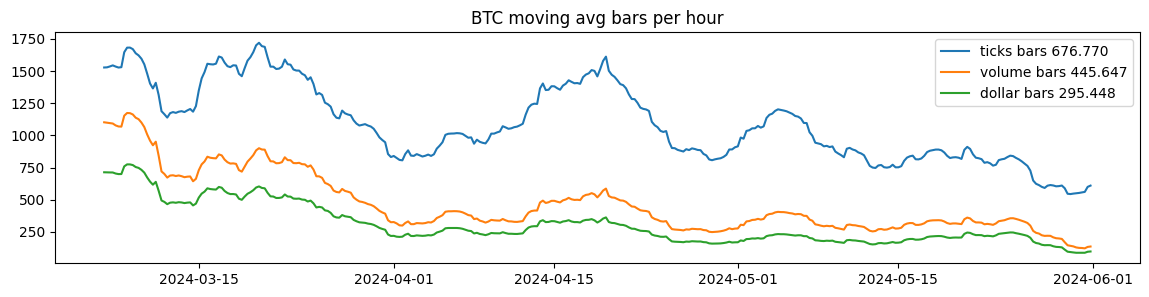

In [81]:
plt.figure(figsize=(14, 3))
count_times = count_samples(btc_ticks, '6h')
plt.plot(count_times['time'], count_times['count'].rolling(window=24).mean(), label=f'ticks bars {np.std(count_times["count"]):.3f}')

count_times = count_samples(btc_volume, '6h')
plt.plot(count_times['time'], count_times['count'].rolling(window=24).mean(), label=f'volume bars {np.std(count_times["count"]):.3f}')

count_times = count_samples(btc_dollar, '6h')
plt.plot(count_times['time'], count_times['count'].rolling(window=24).mean(), label=f'dollar bars {np.std(count_times["count"]):.3f}')
plt.legend(loc='best')
plt.title("BTC moving avg bars per hour")

The windows that im using for each bar is arbitrary and its only 1 month of data but,
`tick bars` has a big variance because every single little trade raise a transaction
`volume bars` is the number of coins that is transfer and is very affected by price of the symbol
`dollar bars` the most stable because its the amount of money that traded, and it represents the actual liquidity of the symbol

#### (c) Serial correlation of returns

In [82]:
def returns(prices):
    return prices.pct_change().dropna()

def serial_correlation(returns):
    return returns.autocorr()

print(f'Ticks bars serial correlation {serial_correlation(returns(btc_ticks["close"]))}')
print(f'Volume bars serial correlation {serial_correlation(returns(btc_volume["close"]))}')
print(f'Dollar bars serial correlation {serial_correlation(returns(btc_dollar["close"]))}')

Ticks bars serial correlation 0.015067275411174027
Volume bars serial correlation -0.011316380263760414
Dollar bars serial correlation -0.005729529805330345


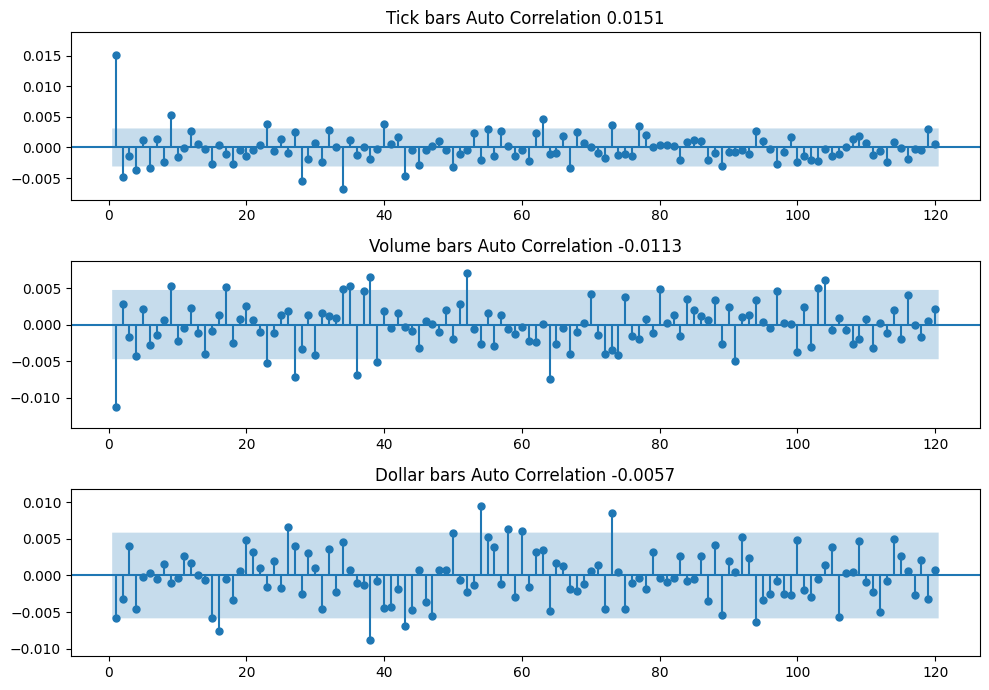

In [74]:
fig, axs = plt.subplots(3, 1, figsize=(10, 7))
plot_autocorr(f'Tick bars Auto Correlation {serial_correlation(returns(btc_ticks["close"])):.4f}',
              returns(btc_ticks["close"]), axs[0])
plot_autocorr(f'Volume bars Auto Correlation {serial_correlation(returns(btc_volume["close"])):.4f}',
              returns(btc_volume["close"]), axs[1])
plot_autocorr(f'Dollar bars Auto Correlation {serial_correlation(returns(btc_dollar["close"])):.4f}',
              returns(btc_dollar["close"]), axs[2])

#### (d) compute the variance for every month (ill do it for every day)

Text(0.5, 1.0, 'BTC variance per week')

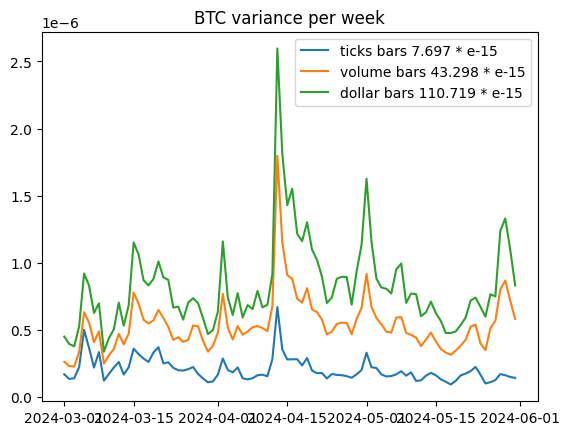

In [9]:
def rolling_variance(df: pd.DataFrame, T: str):
    df['dt_time'] = pd.to_datetime(df['time'], unit='ms')
    df.set_index('dt_time', inplace=True)
    variance_df = returns(df['close']).resample(T).var().reset_index()
    variance_df.columns = ['time', 'variance']
    df.reset_index(inplace=True, drop=True)
    return variance_df

rolling_variance_ticks = rolling_variance(btc_ticks, '1D')
rolling_variance_volume = rolling_variance(btc_volume, '1D')
rolling_variance_dollar = rolling_variance(btc_dollar, '1D')


plt.plot(rolling_variance_ticks['time'], rolling_variance_ticks['variance'], label=f'ticks bars {np.var(rolling_variance_ticks["variance"])*1e15:.3f} * e-15')
plt.plot(rolling_variance_volume['time'], rolling_variance_volume['variance'], label=f'volume bars {np.var(rolling_variance_volume["variance"])*1e15:.3f} * e-15')
plt.plot(rolling_variance_dollar['time'], rolling_variance_dollar['variance'], label=f'dollar bars {np.var(rolling_variance_dollar["variance"])*1e15:.3f} * e-15')
plt.legend(loc='best')
plt.title("BTC variance per week")

tick bars exhibit the smallest variance of variances, as for dollar / volume bars the more money that moves than the prices change as well.

#### (d) apply Jarque-Bera normality test

In [10]:
from scipy.stats import jarque_bera

jb_ticks, p_value_ticks = jarque_bera(returns(btc_ticks['close']))
jb_volume, p_value_volume = jarque_bera(returns(btc_volume['close']))
jb_dollar, p_value_dollar = jarque_bera(returns(btc_dollar['close']))

print(f'Ticks bar Jarque-Bera test: {jb_ticks, p_value_ticks}')
print(f'Volume bar Jarque-Bera test: {jb_volume, p_value_volume}')
print(f'Dollar bar Jarque-Bera test: {jb_dollar, p_value_dollar}')

Ticks bar Jarque-Bera test: (308022.8037118264, 0.0)
Volume bar Jarque-Bera test: (59912.73255180596, 0.0)
Dollar bar Jarque-Bera test: (14869.69861928461, 0.0)


Dollar bar has the smallest Jarque-Bera test statistics even though all of the bars get a p_value of 0 

In [11]:
# no need for these arrays anymore
del btc_ticks
del btc_volume
gc.collect()

0

### 2.2 Dollar bars & Dollars imbalance bars

In [42]:
# from numba_implementations import imbalance_dollar_bar

def imbalance_dollar_bar(prices: np.ndarray, qty: np.ndarray) -> np.ndarray:
    """
    create the imbalance dollar bars as chapter 2 algorithm, the arguments names are similar to the algorithm arguments
    timestamps not mentions in the algorithm is the timestamps corresponding to the transactions
    Args:
        b_t: sign of the diff per transaction
        v_t: dollar or volume  per transaction
        timestamps: timestamps corresponding to the transactions
    Returns:
        imbalance dollar bars
    """
    bucket_size = int(1e7)
    res = np.zeros((7, bucket_size), dtype=np.float32)
    res_index = 0
    prev_T_star = 0
    T = 1
    prev_bt = 1
    prev_p_t = 0
    theta_T = 0
    E_T = 1.0
    estimation_v_plus_v_minus = 0
    while T + prev_T_star < len(prices):
        p_t = prices[prev_T_star + T]
        q_t = qty[prev_T_star + T]
        b_t = prev_bt if prev_p_t == p_t else np.sign(p_t - prev_p_t)
        prev_p_t = p_t

        theta_T += b_t * p_t * q_t
        estimation_v_plus_v_minus = (0.9 * estimation_v_plus_v_minus) + 0.1 * (b_t * p_t * q_t)
        if abs(theta_T) >= E_T * abs(estimation_v_plus_v_minus):
            if res_index >= res.shape[1]:
                # Resize the array if it's full
                new_res = np.zeros((7, res.shape[1] + bucket_size), dtype=np.int32)
                new_res[:, :res.shape[1]] = res
                res = new_res
                
            res[0, res_index] = prev_T_star + T         # open time
            res[1, res_index] = prices[prev_T_star]     # open
            res[2, res_index] = prices[prev_T_star + T] # close
            res[3, res_index] = prices[prev_T_star: prev_T_star + T].max() # high
            res[4, res_index] = prices[prev_T_star: prev_T_star + T].min() # low
            res[5, res_index] = qty[prev_T_star: prev_T_star + T].sum() # volume
            res[6, res_index] = (qty[prev_T_star: prev_T_star + T] * prices[prev_T_star: prev_T_star + T]).sum() # dollars
            res_index += 1
            prev_T_star += T
            
            # estimate E_T
            E_T = 0.5*E_T + 0.5*T
            T = 1
            theta_T = 0
        else:
            T += 1
    return res[:, :res_index]

btc_imbalance_dollar_bar = imbalance_dollar_bar(btc_transactions['price'][:int(5e6)].values,
                           btc_transactions['qty'][:int(5e6)].values, )
len(btc_imbalance_dollar_bar[0,:])

622871

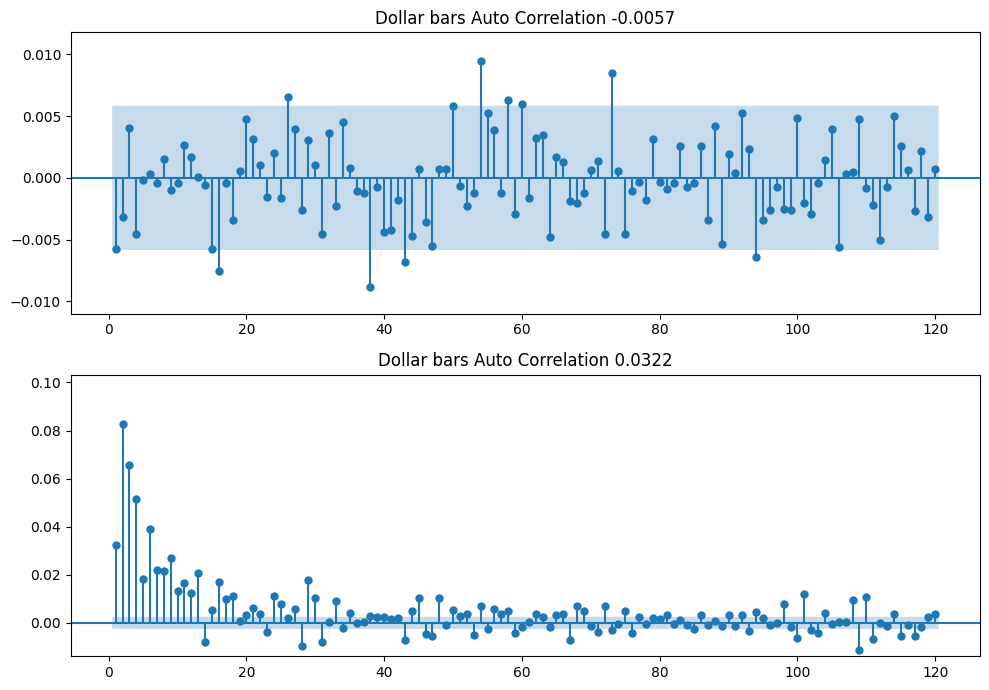

In [75]:
fig, axs = plt.subplots(2, 1, figsize=(10, 7))
plot_autocorr(f'Dollar bars Auto Correlation {serial_correlation(returns(btc_dollar["close"])):.4f}',
              returns(btc_dollar["close"]), axs[0])
plot_autocorr(f'Dollar bars Auto Correlation {serial_correlation(returns(pd.Series(btc_imbalance_dollar_bar[2, :]))):.4f}',
              returns(pd.Series(btc_imbalance_dollar_bar[2, :])), axs[1])

In [4]:
del btc_imbalance_dollar_bar
del btc_dollar
del btc_transactions
gc.collect()

NameError: name 'btc_transactions' is not defined

### 2.3 Dollar bars & Dollars imbalance bars

In [ ]:
dates = ['2024-03', '2024-04', '2024-05']
btc_transactions = load_df(f"Advances-In-Financial-Machine-Learning\data\BTCUSDT-trades-2024-05.csv")
eth_transactions = load_df(f"Advances-In-Financial-Machine-Learning\data\ETHUSDT-trades-2024-05.csv")
sol_transactions = load_df(f"Advances-In-Financial-Machine-Learning\data\SOLUSDT-trades-2024-05.csv")
